In [1]:
import pandas as pd
#import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt
#from matplotlib import style
#import scipy.stats as scs
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt

In [5]:
province_cases = pd.read_csv('https://cnecovid.isciii.es/covid19/resources/casos_tecnica_provincia.csv', parse_dates=['fecha'])
province_cases = province_cases.dropna(subset=['provincia_iso'])

province_cases_uci = pd.read_csv('https://cnecovid.isciii.es/covid19/resources/casos_hosp_uci_def_sexo_edad_provres.csv', parse_dates=['fecha'])
province_cases_uci = province_cases_uci.dropna(subset=['provincia_iso'])


In [7]:
province_cases_uci.head()

,provincia_iso,sexo,grupo_edad,fecha,num_casos,num_hosp,num_uci,num_def
0,A,H,0-9,2020-01-01,0,0,0,0
1,A,H,10-19,2020-01-01,0,0,0,0
2,A,H,20-29,2020-01-01,0,0,0,0
3,A,H,30-39,2020-01-01,0,0,0,0
4,A,H,40-49,2020-01-01,0,0,0,0


In [18]:
num_casos = pd.DataFrame(province_cases_uci.groupby('fecha').sum()['num_casos'])
num_hosp = pd.DataFrame(province_cases_uci.groupby('fecha').sum()['num_hosp'])
num_uci = pd.DataFrame(province_cases_uci.groupby('fecha').sum()['num_uci'])
num_def = pd.DataFrame(province_cases_uci.groupby('fecha').sum()['num_def'])

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

num_casos_sc = scaler.fit_transform(num_casos)
num_hosp_sc = scaler.fit_transform(num_hosp)
num_uci_sc = scaler.fit_transform(num_uci)
num_def_sc = scaler.fit_transform(num_def)

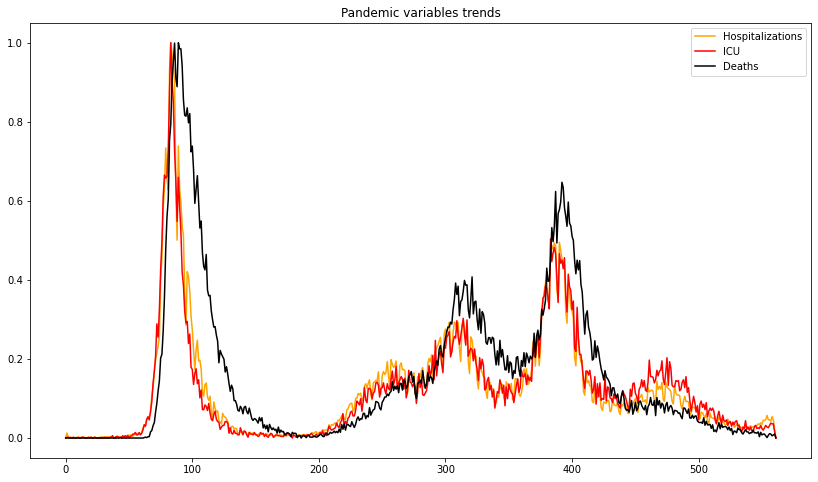

In [52]:
#Plot all trends:
fig = plt.figure(figsize=(14, 8))
#plt.plot(num_casos_sc, color='blue',label='Cases')
plt.plot(num_hosp_sc, color='orange', label='Hospitalizations')
plt.plot(num_uci_sc, color='red', label = 'ICU')
plt.plot(num_def_sc, color='black', label = 'Deaths')
plt.legend(loc='best')
plt.title('Pandemic variables trends')
plt.show()

array([[<AxesSubplot:title={'center':'num_casos'}>]], dtype=object)

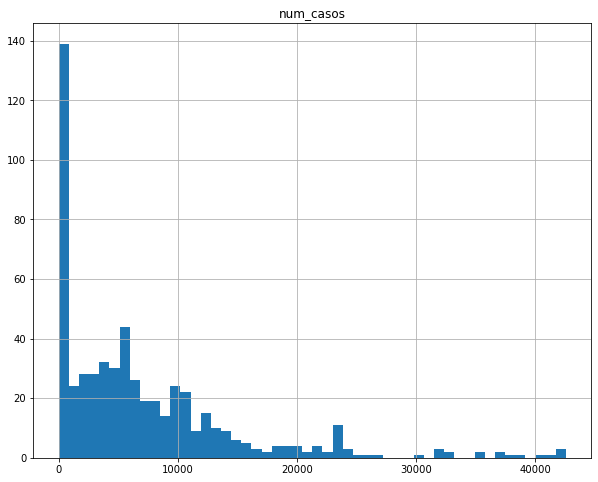

In [14]:
data.hist(bins=50, figsize=(10,8))

<Figure size 432x288 with 0 Axes>

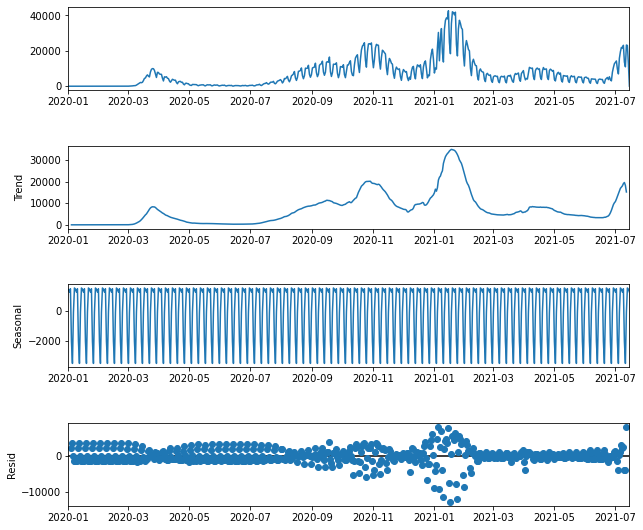

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data, period=7)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(10, 8)

In [28]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean()
    rolstd = timeseries.rolling(window=7).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput) 

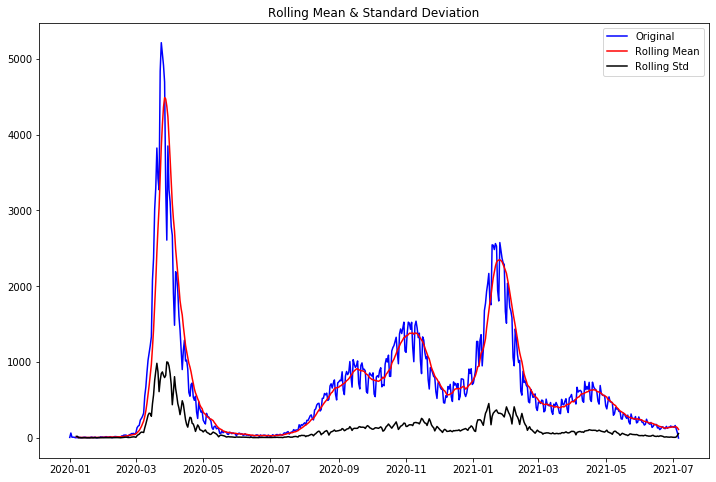

Results of Dickey-Fuller Test:
Test Statistic                  -3.533331
p-value                          0.007171
#Lags Used                      19.000000
Number of Observations Used    533.000000
Critical Value (1%)             -3.442678
Critical Value (5%)             -2.866978
Critical Value (10%)            -2.569666
dtype: float64


In [10]:
test_stationarity(data)

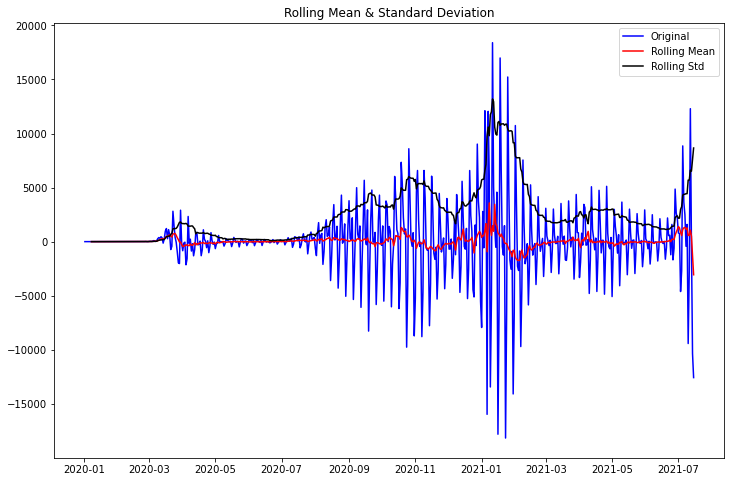

Results of Dickey-Fuller Test:
Test Statistic                  -5.528444
p-value                          0.000002
#Lags Used                      18.000000
Number of Observations Used    542.000000
Critical Value (1%)             -3.442473
Critical Value (5%)             -2.866887
Critical Value (10%)            -2.569618
dtype: float64


In [30]:
data = num_casos
data['first_diff'] = data.num_casos - data.num_casos.shift(1)
test_stationarity(data.first_diff.dropna(inplace=False))

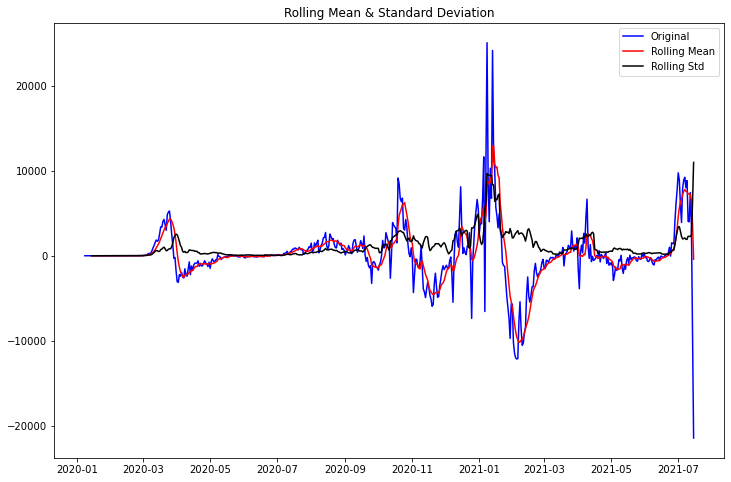

Results of Dickey-Fuller Test:
Test Statistic                  -5.236753
p-value                          0.000007
#Lags Used                      17.000000
Number of Observations Used    537.000000
Critical Value (1%)             -3.442586
Critical Value (5%)             -2.866937
Critical Value (10%)            -2.569645
dtype: float64


In [33]:
data['seasonal_diff'] = data.num_casos - data.num_casos.shift(7)
test_stationarity(data.seasonal_diff.dropna(inplace=False))

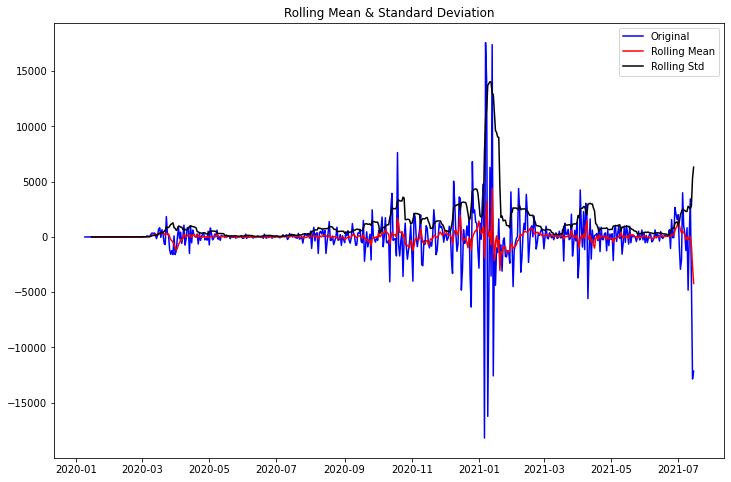

Results of Dickey-Fuller Test:
Test Statistic                  -5.324049
p-value                          0.000005
#Lags Used                      15.000000
Number of Observations Used    538.000000
Critical Value (1%)             -3.442563
Critical Value (5%)             -2.866927
Critical Value (10%)            -2.569639
dtype: float64


In [34]:
data['seasonal_first_diff'] = data.first_diff - data.first_diff.shift(7)
test_stationarity(data.seasonal_first_diff.dropna(inplace=False))

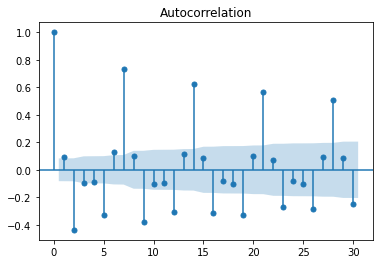

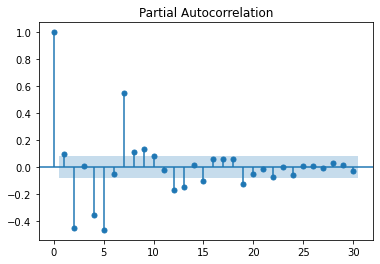

In [41]:
plot_acf(data.first_diff.iloc[1:], lags=30);
plot_pacf(data.first_diff.iloc[1:], lags=30);

In [32]:
#Build AR model
from statsmodels.tsa.arima_model import ARIMA
 
# fit model
model = ARIMA(data['num_casos'], order=(10,1,0), freq='D')
model_fit = model.fit(update_freq=5, disp=0)
print(model_fit.summary())

C:\Users\drodriguez45\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:            D.num_casos   No. Observations:                  561
Model:                ARIMA(10, 1, 0)   Log Likelihood               -5053.976
Method:                       css-mle   S.D. of innovations           1967.649
Date:                Sun, 18 Jul 2021   AIC                          10131.951
Time:                        13:47:43   BIC                          10183.908
Sample:                    01-02-2020   HQIC                         10152.237
                         - 07-15-2021                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -15.8348    103.832     -0.153      0.879    -219.342     187.672
ar.L1.D.num_casos     -0.1753      0.045     -3.897      0.000      -0.263      -0.087
ar.L2.D.num_casos   

In [ ]:
#Build seasonal model
import statsmodels.api as sm

model = sm.tsa.statespace.SARIMAX(df.num_casos, trend='n', order=(6,0,0), seasonal_order=(4,1,0,7), simple_differencing=True)
model_fit = model.fit()
print(results.summary())

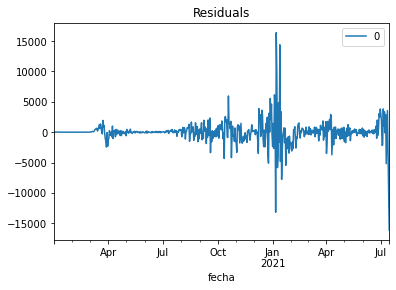

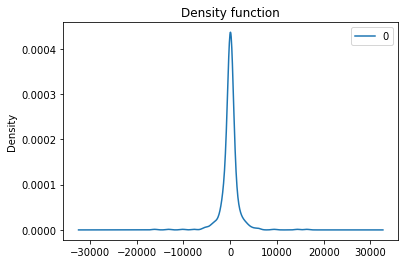

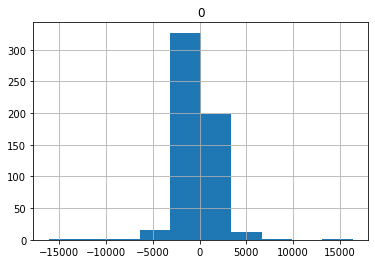

                  0
count    561.000000
mean       1.108308
std     1969.405825
min   -16135.769038
25%     -320.415572
50%       17.787266
75%      429.163997
max    16390.891844


In [40]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.title('Residuals')
plt.show()
residuals.plot(kind='kde')
plt.title('Density function')
plt.show()
# histogram plot
residuals.hist()
plt.show()
print(residuals.describe())

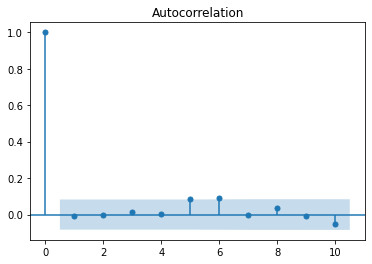

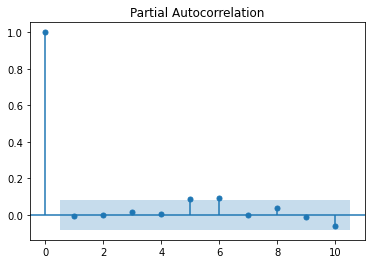

In [42]:
plot_acf(residuals, lags=10);
plot_pacf(residuals, lags=10);

No ACF or PACF, it seems WN. Check with formal BoxTest. ***H0 the time series isn't autocorrelated***

In [47]:
from statsmodels.stats.diagnostic import acorr_ljungbox as boxtest

boxtest(residuals, lags=[14], boxpierce=True, return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
14,15.679549,0.333333,15.402403,0.351212


In [48]:
#Train and test split
print(data.shape)
train = data.iloc[:-10]
test = data.iloc[-10:]
print(train.shape, test.shape)

(562, 4)
(552, 4) (10, 4)


In [57]:
# fit model
model = ARIMA(train['num_casos'], order=(10,1,0), freq='D')
model_fit = model.fit(update_freq=5, disp=0)
print(model_fit.summary())

C:\Users\drodriguez45\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:            D.num_casos   No. Observations:                  551
Model:                ARIMA(10, 1, 0)   Log Likelihood               -4901.061
Method:                       css-mle   S.D. of innovations           1754.547
Date:                Sun, 18 Jul 2021   AIC                           9826.123
Time:                        14:01:03   BIC                           9877.863
Sample:                    01-02-2020   HQIC                          9846.340
                         - 07-05-2021                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 51.0964    105.099      0.486      0.627    -154.895     257.088
ar.L1.D.num_casos     -0.2832      0.042     -6.687      0.000      -0.366      -0.200
ar.L2.D.num_casos   

In [58]:
#Make predictions
start = len(train)
end = len(train) + len(test) - 1
pred = model_fit.predict(start=start, end=end, typ='levels')
#pred.index=data.index[start:end +1]
print(pred)

2021-07-06    18198.577450
2021-07-07    17704.969167
2021-07-08    19042.365094
2021-07-09    18983.908003
2021-07-10    14886.330860
2021-07-11    13127.018400
2021-07-12    19494.534895
2021-07-13    22396.251990
2021-07-14    21631.319182
2021-07-15    22813.548076
Freq: D, dtype: float64


<AxesSubplot:xlabel='fecha'>

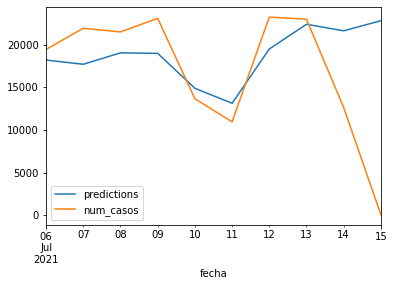

In [59]:
pred.plot(legend=True, label='predictions')
test['num_casos'].plot(legend=True)

In [60]:
test['num_casos'].mean()

16949.7

In [61]:
rmse = sqrt(mean_squared_error(pred[:7], test['num_casos'][:7]))
print(rmse)

2991.0629783704003


## Rolling forecast

In [62]:
history = [x for x in train['num_casos']]
predictions = []


for t in range(len(test)):
    model = ARIMA(history, order=(10,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test['num_casos'][t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

C:\Users\drodriguez45\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=18198.577450, expected=19440.000000
predicted=18603.997381, expected=21930.000000
predicted=21884.233057, expected=21500.000000
predicted=20401.488550, expected=23094.000000
predicted=18873.404954, expected=13669.000000
predicted=12370.039330, expected=10947.000000
predicted=19858.347902, expected=23245.000000
predicted=26550.582161, expected=22990.000000
predicted=23479.192727, expected=12629.000000
predicted=18126.140986, expected=53.000000


In [63]:
predictions

[array([18198.57744963]),
 array([18603.99738067]),
 array([21884.23305718]),
 array([20401.48855]),
 array([18873.40495417]),
 array([12370.03933021]),
 array([19858.34790248]),
 array([26550.58216103]),
 array([23479.19272658]),
 array([18126.1409864])]

In [64]:
predictions = pd.DataFrame(predictions, index = test.index)

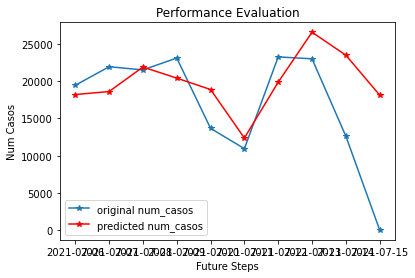

In [67]:
# plot
plt.plot(test.num_casos, label = 'original num_casos', marker = '*')
plt.plot(predictions, color='red', label = 'predicted num_casos', marker = '*')
plt.title('Performance Evaluation')
plt.xlabel('Future Steps')
plt.ylabel('Num Casos')
plt.legend()
plt.show()

In [68]:
rmse = sqrt(mean_squared_error(predictions[:7], test['num_casos'][:7]))
print(rmse)

2941.8400610837793


### A volatility model could be used, but no sense in this problem

Remember we need mean zero (0) to use the squared 

Text(0.5, 1.0, 'Residuals squared')

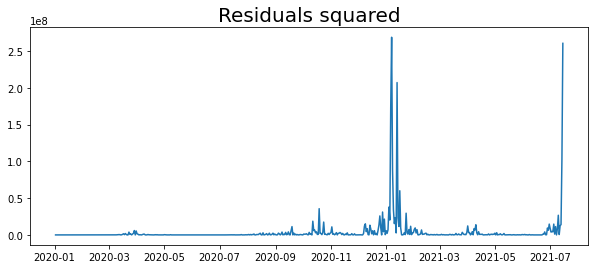

In [69]:
plt.figure(figsize=(10,4))
plt.plot(residuals**2)
plt.title('Residuals squared', fontsize=20)

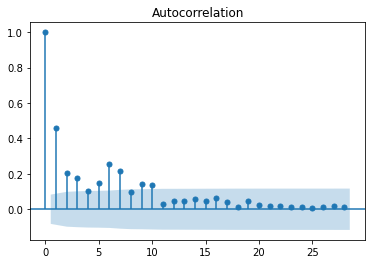

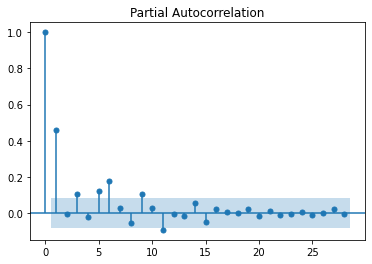

In [70]:
plot_acf(residuals**2);
plot_pacf(residuals**2);

In [71]:
from arch import arch_model

model = arch_model(residuals, p=5, o=1, q=0, dist="StudentsT")
model_fit = model.fit(update_freq=20, disp=False)
print(model_fit.summary())


C:\Users\drodriguez45\Anaconda3\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.872e+06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Iteration:     20,   Func. Count:    211,   Neg. LLF: 4563.52280086174
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            0   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -4563.51
Distribution:      Standardized Student's t   AIC:                           9145.02
Method:                  Maximum Likelihood   BIC:                           9183.99
                                              No. Observations:                  561
Date:                      Sun, Jul 18 2021   Df Residuals:                      552
Time:                              14:05:14   Df Model:                            9
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------

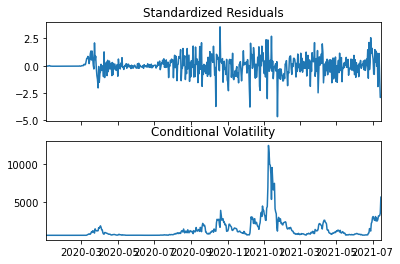

In [72]:
model_fit.plot();

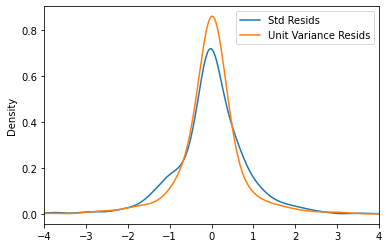

In [73]:
std_resid = model_fit.resid / model_fit.conditional_volatility
unit_var_resid = model_fit.resid / model_fit.resid.std()
df2 = pd.concat([std_resid, unit_var_resid], 1)
df2.columns = ["Std Resids", "Unit Variance Resids"]
subplot = df2.plot(kind="kde", xlim=(-4, 4))

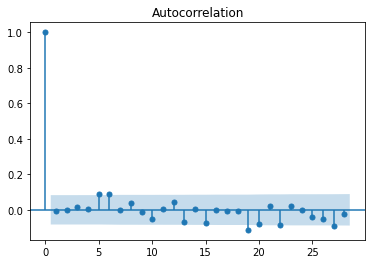

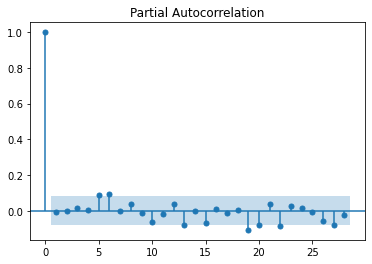

In [74]:
plot_acf(model_fit.resid);
plot_pacf(model_fit.resid);

In [75]:
pd.DataFrame(model_fit.params)

,params
mu,43.235436
omega,387164.527296
alpha[1],0.378762
alpha[2],0.241221
alpha[3],0.139041
alpha[4],0.167551
alpha[5],0.158569
gamma[1],-0.170289
nu,2.685701


In [76]:
sim_mod = arch_model(None, p=5, o=1, q=0, dist="StudentsT")

sim_data = sim_mod.simulate(model_fit.params, 1000)
sim_data.head()

,data,volatility,errors
0,332.782430,846.563714,289.546994
1,-1047.169026,781.395041,-1090.404462
2,-540.141577,938.257505,-583.377013
3,-454.033280,984.787891,-497.268716
4,-347.019798,837.381687,-390.255234


C:\Users\drodriguez45\Anaconda3\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.872e+06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Iteration:     20,   Func. Count:    211,   Neg. LLF: 4563.52280086174


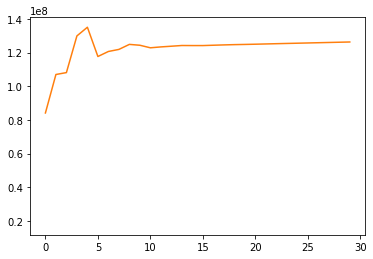

In [77]:
# split into train/test
n_test = 30
train, test = residuals[:-n_test], residuals[-n_test:]

model = arch_model(residuals,  p=5, o=1, q=0, dist="StudentsT")
model_fit = model.fit(update_freq=20, disp=False)

# forecast the test set
yhat = model_fit.forecast(horizon=n_test)
# plot the actual variance
plt.plot(test.var())
# plot forecast variance
plt.plot(yhat.variance.values[-1, :])
plt.show()